In [1]:
# -*- coding: utf-8 -*-
"""
Three-model pipeline on APTOS/EyePACS-style folders using EfficientNetB3.

- Model 1: Binary Low(0,1) vs High(2,3,4).
- Model 2: Binary 0 vs 1.
- Model 3: Ordinal for {2,3,4} with 2-bit targets [y>=3, y>=4].
  Mapping: 2 -> [0,0], 3 -> [1,0], 4 -> [1,1].

Training strategy (for all 3):
Stage 1: freeze EfficientNetB3 (backbone), train only head.
Stage 2: fine-tune in 3 states, unfreezing blocks progressively:
         State A: block6, block7
         State B: block4..7
         State C: block1..7
At each stage we save a .keras file and reload before the next stage.
"""

import os, gc, json, math, time, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import cohen_kappa_score

2025-08-19 17:32:59.499058: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-19 17:32:59.592320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755639179.636305    8095 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755639179.650516    8095 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755639179.735028    8095 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:


# ================== GPU & Seed ==================
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass

# ================== CONFIG ==================
# Thay đổi cho phù hợp dataset của bạn
TRAIN_DIR = "/home/duc/Documents/DoAn/eyepacs_2015/train_preprocess_ben_graham"
VAL_DIR   = "/home/duc/Documents/DoAn/eyepacs_2015/val_preprocess_ben_graham"

IMAGE_SIZE = 300 #448
BATCH_SIZE = 8

HEAD_EPOCHS = 10          # epochs cho stage 1 (train head)
FT_EPOCHS   = 10          # epochs cho mỗi state fine-tuning

LR_HEAD = 3e-4            # LR stage 1
LR_FT   = [1e-4, 5e-5, 3e-5]   # LR cho 3 state fine-tune
WEIGHT_DECAY = 1e-4

DROP_RATE   = 0.4
DENSE_UNITS = 1024

MODELS_DIR = "output_three_models_eyepacs"
os.makedirs(MODELS_DIR, exist_ok=True)

AUTOTUNE = tf.data.AUTOTUNE

# ================== EfficientNetB3 & Preprocess ==================
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input

# ================== Attention block (nhẹ) ==================
def sca_block(x, ratio=8, name="sca"):
    """Simple Channel Attention: GAP -> reduce(1x1) -> gate(1x1 sigmoid) -> multiply."""
    ch = int(x.shape[-1])
    mid = max(ch // ratio, 1)
    gap = layers.GlobalAveragePooling2D(keepdims=True, name=f"{name}_gap")(x)
    red = layers.Conv2D(mid, 1, padding="same", activation="relu", use_bias=True, name=f"{name}_reduce")(gap)
    gate= layers.Conv2D(ch,  1, padding="same", activation="sigmoid", use_bias=True, name=f"{name}_gate")(red)
    return layers.Multiply(name=f"{name}_mul")([x, gate])

# ================== Dataset helpers ==================
def _map_img(img, lbl):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img, lbl

def _ds_from_dir(data_dir, class_names, shuffle, seed=SEED):
    # Chỉ lấy các class cần (class_names có thể là ["0","1","2","3","4"] hoặc ["0","1"] hay ["2","3","4"])
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="int",
        class_names=class_names,            # Only these classes are included
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=shuffle,
        seed=seed
    )
    return ds


In [5]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1", threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return tf.where(p + r > 0, 2.0 * p * r / (p + r), 0.0)

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [6]:
def enforce_monotonic_ord_np(p_ord):
    p = p_ord.copy()
    p[:, 1] = np.minimum(p[:, 1], p[:, 0])  # p_ge4 <= p_ge3
    return p

def bits_to_234_np(bits):
    out = np.full((bits.shape[0],), 3, dtype=np.int32)
    cond00 = (bits[:, 0] == 0) & (bits[:, 1] == 0)
    cond10 = (bits[:, 0] == 1) & (bits[:, 1] == 0)
    cond11 = (bits[:, 0] == 1) & (bits[:, 1] == 1)
    out[cond00] = 2
    out[cond10] = 3
    out[cond11] = 4
    return out


In [7]:
class OrdinalQWKCheckpoint(tf.keras.callbacks.Callback):
    """
    Tính QWK trên ds_val (nhãn 2-bit [y>=3, y>=4]) sau mỗi epoch.
    Lưu model vào filepath nếu QWK cải thiện.
    """
    def __init__(self, val_ds, filepath, th=0.5):
        super().__init__()
        self.val_ds = val_ds
        self.filepath = filepath
        self.th = th
        self.best = -np.inf

    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = [], []
        for xb, yb in self.val_ds:
            # yb: (B,2) -> true labels {2,3,4}
            yb_np = yb.numpy()
            true_bits = (yb_np >= 0.5).astype(int)
            true_234 = bits_to_234_np(true_bits)

            # predict
            p = self.model.predict(xb, verbose=0)  # (B,2) [p_ge3, p_ge4]
            p = enforce_monotonic_ord_np(p)
            bits = (p >= self.th).astype(int)
            pred_234 = bits_to_234_np(bits)

            # map 2,3,4 -> 0,1,2 để tính kappa ổn định
            y_true.append(true_234 - 2)
            y_pred.append(pred_234 - 2)

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        if logs is not None:
            logs["val_qwk"] = qwk  # để hiển thị trong log

        if qwk > self.best:
            self.best = qwk
            self.model.save(self.filepath)
        print(f"\nEpoch {epoch+1}: val_qwk={qwk:.4f} (best={self.best:.4f})")


In [3]:

# -------- Model 1: Low(0,1) vs High(2,3,4) --------
def map_label_low_high(label_int):
    # label_int in {0,1,2,3,4} -> 0 if in {0,1}, else 1
    y = tf.where(label_int <= 1, 0, 1)
    y = tf.cast(y, tf.float32)
    return y

def map_preprocess_m1(img, lbl):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    y = map_label_low_high(lbl)
    y = tf.expand_dims(y, axis=-1)  # (B,1) sigmoid
    return img, y

def make_ds_m1(train_dir, val_dir):
    class_names = ["0","1","2","3","4"]
    ds_tr = _ds_from_dir(train_dir, class_names, shuffle=True).map(map_preprocess_m1, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_va = _ds_from_dir(val_dir,   class_names, shuffle=False).map(map_preprocess_m1, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds_tr, ds_va

# -------- Model 2: Binary 0 vs 1 --------
def map_preprocess_m2(img, lbl):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    y = tf.cast(lbl, tf.float32)      # lbl ∈ {0,1}
    y = tf.expand_dims(y, axis=-1)    # (B,1) sigmoid
    return img, y

def make_ds_m2(train_dir, val_dir):
    class_names = ["0","1"]  # chỉ lấy hai lớp này, tự động bỏ qua 2,3,4 nếu có
    ds_tr = _ds_from_dir(train_dir, class_names, shuffle=True).map(map_preprocess_m2, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_va = _ds_from_dir(val_dir,   class_names, shuffle=False).map(map_preprocess_m2, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds_tr, ds_va

# -------- Model 3: Ordinal for {2,3,4} with 2-bit [y>=3, y>=4] --------
def ordinal_encode_234(label_idx):
    """
    label_idx is index over class_names=["2","3","4"], i.e. values in {0,1,2}
    We need two bits: [y>=3, y>=4] which is equivalent to [label_idx>=1, label_idx>=2].
    2 -> 0 -> [0,0]
    3 -> 1 -> [1,0]
    4 -> 2 -> [1,1]
    """
    t1 = tf.cast(label_idx >= 1, tf.float32)
    t2 = tf.cast(label_idx >= 2, tf.float32)
    y = tf.stack([t1, t2], axis=-1)  # (B,2)
    return y

def map_preprocess_m3(img, lbl_idx):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    y = ordinal_encode_234(lbl_idx)
    return img, y

def make_ds_m3(train_dir, val_dir):
    class_names = ["2","3","4"]
    ds_tr = _ds_from_dir(train_dir, class_names, shuffle=True).map(map_preprocess_m3, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_va = _ds_from_dir(val_dir,   class_names, shuffle=False).map(map_preprocess_m3, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds_tr, ds_va

# ================== Model builders ==================
def build_backbone_b3(inputs, freeze=True):
    base = EfficientNetB3(include_top=False, weights="imagenet", input_tensor=inputs)
    base.trainable = not freeze
    return base

def build_head(x, drop=DROP_RATE, units=DENSE_UNITS, name_prefix="head"):
    x = sca_block(x, ratio=8, name=f"{name_prefix}_sca")
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(drop)(x)
    x = layers.Dense(units, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(drop * 0.75)(x)
    return x

# ---- Model 1: binary Low vs High (sigmoid 1 unit) ----
def build_model_1(img_size=IMAGE_SIZE, freeze_backbone=True):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    base = build_backbone_b3(inputs, freeze=freeze_backbone)
    x = build_head(base.output, name_prefix="m1")
    out = layers.Dense(1, activation="sigmoid", name="bin")(x)
    return models.Model(inputs, out, name="EffB3_M1_LowHigh")

# ---- Model 2: binary 0 vs 1 (sigmoid 1 unit) ----
def build_model_2(img_size=IMAGE_SIZE, freeze_backbone=True):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    base = build_backbone_b3(inputs, freeze=freeze_backbone)
    x = build_head(base.output, name_prefix="m2")
    out = layers.Dense(1, activation="sigmoid", name="bin")(x)
    return models.Model(inputs, out, name="EffB3_M2_0vs1")

# ---- Model 3: ordinal for 2,3,4 → 2-bit sigmoid [y>=3, y>=4] ----
def build_model_3(img_size=IMAGE_SIZE, freeze_backbone=True):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    base = build_backbone_b3(inputs, freeze=freeze_backbone)
    x = build_head(base.output, name_prefix="m3")
    out = layers.Dense(2, activation="sigmoid", name="ord2")(x)
    return models.Model(inputs, out, name="EffB3_M3_234Ordinal")

# ================== Compile helpers ==================
def compile_binary(model, lr, wd=WEIGHT_DECAY):
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), tf.keras.metrics.AUC(name="auc")]
    )
    return model

def compile_multi_sigmoid(model, lr, wd=WEIGHT_DECAY):
    # For model 3: 2 independent sigmoids (multi-label BCE)
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)]
    )
    return model

# ================== Fine-tune utilities ==================
def set_trainable_blocks(model, prefixes_to_unfreeze):
    """
    Unfreeze all layers whose names start with any prefix in prefixes_to_unfreeze.
    Keep BatchNormalization layers frozen to avoid instability.
    """
    for layer in model.layers:
        name = getattr(layer, "name", "")
        if any(name.startswith(pfx) for pfx in prefixes_to_unfreeze):
            layer.trainable = True
        # Freeze all BN layers
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

def run_stage_training(model, ds_train, ds_val, epochs, lr, ckpt_path, is_binary=True):
    # Recompile per stage with updated LR
    if is_binary:
        compile_binary(model, lr)
    else:
        compile_multi_sigmoid(model, lr)

    cbs = [
        tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=3, min_lr=1e-6),
        tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_auc", save_best_only=True)
    ]
    history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=cbs, verbose=1)
    # Save final snapshot (optional, but we already save best via ModelCheckpoint)
    model.save(ckpt_path)
    return history

def staged_finetune_pipeline(model_name_prefix,
                             build_fn,
                             ds_train,
                             ds_val,
                             is_binary,
                             head_epochs=HEAD_EPOCHS,
                             ft_epochs=FT_EPOCHS,
                             lr_head=LR_HEAD,
                             lr_stages=LR_FT):
    """
    Generic 4-stage pipeline:
      Stage 1: Train head (frozen backbone)
      Stage 2: unfreeze block6..7
      Stage 3: unfreeze block4..7
      Stage 4: unfreeze block1..7
    """
    # -------- Stage 1 --------
    s1_path = os.path.join(MODELS_DIR, f"{model_name_prefix}_stage1.keras")
    if os.path.exists(s1_path):
        print(f"[{model_name_prefix}] Found Stage1 checkpoint, loading:", s1_path)
        model = tf.keras.models.load_model(s1_path, compile=False)
    else:
        print(f"\n[{model_name_prefix}] === Stage 1: Train head (backbone frozen) ===")
        model = build_fn(freeze_backbone=True)
        if is_binary:
            compile_binary(model, lr_head)
        else:
            compile_multi_sigmoid(model, lr_head)
        run_stage_training(model, ds_train, ds_val, head_epochs, lr_head, s1_path, is_binary=is_binary)

    # -------- Stage 2~4 (fine-tuning) --------
    stage_blocks = [
        ["block6", "block7"],
        ["block4", "block5", "block6", "block7"],
        ["block1", "block2", "block3", "block4", "block5", "block6", "block7"],
    ]
    for idx, (prefixes, lr) in enumerate(zip(stage_blocks, lr_stages), start=2):
        ck = os.path.join(MODELS_DIR, f"{model_name_prefix}_stage{idx}.keras")
        if os.path.exists(ck):
            print(f"[{model_name_prefix}] Found Stage{idx} checkpoint, loading:", ck)
            continue
        # Always reload previous best to reduce memory usage and ensure good init
        prev = os.path.join(MODELS_DIR, f"{model_name_prefix}_stage{idx-1}.keras")
        print(f"\n[{model_name_prefix}] === Stage {idx}: Unfreeze {prefixes} ===")
        model = tf.keras.models.load_model(prev, compile=False)
        set_trainable_blocks(model, prefixes)
        # Keep head layers trainable by default (already True)
        run_stage_training(model, ds_train, ds_val, ft_epochs, lr, ck, is_binary=is_binary)

    print(f"\n[{model_name_prefix}] === Completed all stages ===")



In [4]:
# ================== MAIN ==================

    # -------- Datasets for each model --------
tf.keras.backend.clear_session(); gc.collect()
print("Preparing datasets...")
ds1_train, ds1_val = make_ds_m1(TRAIN_DIR, VAL_DIR)   # Low vs High
ds2_train, ds2_val = make_ds_m2(TRAIN_DIR, VAL_DIR)   # 0 vs 1
ds3_train, ds3_val = make_ds_m3(TRAIN_DIR, VAL_DIR)   # 2/3/4 ordinal 2-bit





Preparing datasets...
Found 105145 files belonging to 5 classes.


I0000 00:00:1755639194.610595    8095 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2281 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 3511 files belonging to 5 classes.
Found 44039 files belonging to 2 classes.
Found 2824 files belonging to 2 classes.
Found 61106 files belonging to 3 classes.
Found 687 files belonging to 3 classes.


In [ ]:
    # -------- Model 1 pipeline --------
tf.keras.backend.clear_session(); gc.collect()
staged_finetune_pipeline(
        model_name_prefix="effb3_low_high",
        build_fn=lambda freeze_backbone=True: build_model_1(IMAGE_SIZE, freeze_backbone),
        ds_train=ds1_train,
        ds_val=ds1_val,
        is_binary=True,
        head_epochs=HEAD_EPOCHS,
        ft_epochs=FT_EPOCHS,
        lr_head=LR_HEAD,
        lr_stages=LR_FT
    )


[effb3_low_high] Found Stage1 checkpoint, loading: output_three_models_eyepacs/effb3_low_high_stage1.keras

[effb3_low_high] === Stage 2: Unfreeze ['block6', 'block7'] ===
Epoch 1/10


I0000 00:00:1755509448.541587    3446 service.cc:152] XLA service 0x7212380026e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755509448.541614    3446 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-18 05:30:49.177395: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755509451.918269    3446 cuda_dnn.cc:529] Loaded cuDNN version 90300


    2/13144 ━━━━━━━━━━━━━━━━━━━━ 13:44 63ms/step - acc: 0.9375 - auc: 0.2768 - loss: 0.3939       

I0000 00:00:1755509473.804593    3446 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13144/13144 ━━━━━━━━━━━━━━━━━━━━ 851s 62ms/step - acc: 0.8303 - auc: 0.9072 - loss: 0.3722 - val_acc: 0.8801 - val_auc: 0.8526 - val_loss: 0.3255 - learning_rate: 1.0000e-04
Epoch 2/10
13144/13144 ━━━━━━━━━━━━━━━━━━━━ 780s 59ms/step - acc: 0.8846 - auc: 0.9517 - loss: 0.2669 - val_acc: 0.8715 - val_auc: 0.8645 - val_loss: 0.3357 - learning_rate: 1.0000e-04
Epoch 3/10
13144/13144 ━━━━━━━━━━━━━━━━━━━━ 782s 59ms/step - acc: 0.9151 - auc: 0.9711 - loss: 0.2078 - val_acc: 0.8641 - val_auc: 0.8627 - val_loss: 0.3841 - learning_rate: 1.0000e-04
Epoch 4/10
13144/13144 ━━━━━━━━━━━━━━━━━━━━ 781s 59ms/step - acc: 0.9360 - auc: 0.9818 - loss: 0.2188 - val_acc: 0.8539 - val_auc: 0.8552 - val_loss: 0.4152 - learning_rate: 1.0000e-04
Epoch 5/10
13144/13144 ━━━━━━━━━━━━━━━━━━━━ 781s 59ms/step - acc: 0.9494 - auc: 0.9884 - loss: 0.1305 - val_acc: 0.8604 - val_auc: 0.8692 - val_loss: 0.4945 - learning_rate: 5.0000e-05
Epoch 6/10
13144/13144 ━━━━━━━━━━━━━━━━━━━━ 780s 59ms/step - acc: 0.9673 - auc: 0.9947

2025-08-18 08:38:05.319626: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


13144/13144 ━━━━━━━━━━━━━━━━━━━━ 1580s 116ms/step - acc: 0.9391 - auc: 0.9832 - loss: 0.1532 - val_acc: 0.8852 - val_auc: 0.8876 - val_loss: 0.3669 - learning_rate: 3.0000e-05
Epoch 2/10
13144/13144 ━━━━━━━━━━━━━━━━━━━━ 1495s 114ms/step - acc: 0.9651 - auc: 0.9938 - loss: 0.0914 - val_acc: 0.8952 - val_auc: 0.8758 - val_loss: 0.4325 - learning_rate: 3.0000e-05
Epoch 3/10
13144/13144 ━━━━━━━━━━━━━━━━━━━━ 1496s 114ms/step - acc: 0.9784 - auc: 0.9973 - loss: 0.0584 - val_acc: 0.8673 - val_auc: 0.8824 - val_loss: 0.4690 - learning_rate: 3.0000e-05
Epoch 4/10
13144/13144 ━━━━━━━━━━━━━━━━━━━━ 1495s 114ms/step - acc: 0.9839 - auc: 0.9984 - loss: 0.0433 - val_acc: 0.8832 - val_auc: 0.8674 - val_loss: 0.4822 - learning_rate: 3.0000e-05
Epoch 5/10
13144/13144 ━━━━━━━━━━━━━━━━━━━━ 1493s 114ms/step - acc: 0.9915 - auc: 0.9995 - loss: 0.0231 - val_acc: 0.8613 - val_auc: 0.8688 - val_loss: 0.6882 - learning_rate: 1.5000e-05
Epoch 6/10
13144/13144 ━━━━━━━━━━━━━━━━━━━━ 1495s 114ms/step - acc: 0.9942 -

In [5]:
    # -------- Model 2 pipeline --------
tf.keras.backend.clear_session(); gc.collect()
staged_finetune_pipeline(
        model_name_prefix="effb3_0_vs_1",
        build_fn=lambda freeze_backbone=True: build_model_2(IMAGE_SIZE, freeze_backbone),
        ds_train=ds2_train,
        ds_val=ds2_val,
        is_binary=True,
        head_epochs=HEAD_EPOCHS,
        ft_epochs=FT_EPOCHS,
        lr_head=LR_HEAD,
        lr_stages=LR_FT
    )



[effb3_0_vs_1] Found Stage1 checkpoint, loading: output_three_models_eyepacs/effb3_0_vs_1_stage1.keras
[effb3_0_vs_1] Found Stage2 checkpoint, loading: output_three_models_eyepacs/effb3_0_vs_1_stage2.keras
[effb3_0_vs_1] Found Stage3 checkpoint, loading: output_three_models_eyepacs/effb3_0_vs_1_stage3.keras

[effb3_0_vs_1] === Stage 4: Unfreeze ['block1', 'block2', 'block3', 'block4', 'block5', 'block6', 'block7'] ===
Epoch 1/10


I0000 00:00:1755571502.687126    4749 service.cc:152] XLA service 0x71a77c015b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755571502.687170    4749 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-18 22:45:03.587082: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755571507.520785    4749 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755571546.845145    4749 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-08-18 22:45:46.879226: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this messa

5505/5505 ━━━━━━━━━━━━━━━━━━━━ 737s 123ms/step - acc: 0.9589 - auc: 0.9867 - loss: 0.1168 - val_acc: 0.4749 - val_auc: 0.5559 - val_loss: 2.9883 - learning_rate: 3.0000e-05
Epoch 2/10
5505/5505 ━━━━━━━━━━━━━━━━━━━━ 632s 115ms/step - acc: 0.9707 - auc: 0.9930 - loss: 0.0849 - val_acc: 0.4356 - val_auc: 0.5425 - val_loss: 9.3072 - learning_rate: 3.0000e-05
Epoch 3/10
5505/5505 ━━━━━━━━━━━━━━━━━━━━ 629s 114ms/step - acc: 0.9781 - auc: 0.9961 - loss: 0.0633 - val_acc: 0.4522 - val_auc: 0.5463 - val_loss: 7.2177 - learning_rate: 3.0000e-05
Epoch 4/10
5505/5505 ━━━━━━━━━━━━━━━━━━━━ 631s 115ms/step - acc: 0.9835 - auc: 0.9979 - loss: 0.0472 - val_acc: 0.4458 - val_auc: 0.5331 - val_loss: 12.0795 - learning_rate: 3.0000e-05
Epoch 5/10
5505/5505 ━━━━━━━━━━━━━━━━━━━━ 629s 114ms/step - acc: 0.9864 - auc: 0.9988 - loss: 0.0366 - val_acc: 0.3566 - val_auc: 0.5482 - val_loss: 12.2306 - learning_rate: 3.0000e-05
Epoch 6/10
5505/5505 ━━━━━━━━━━━━━━━━━━━━ 633s 115ms/step - acc: 0.9883 - auc: 0.9991 - l

In [5]:
    # -------- Model 3 pipeline --------
tf.keras.backend.clear_session(); gc.collect()
staged_finetune_pipeline(
        model_name_prefix="effb3_234_ordinal2bit",
        build_fn=lambda freeze_backbone=True: build_model_3(IMAGE_SIZE, freeze_backbone),
        ds_train=ds3_train,
        ds_val=ds3_val,
        is_binary=False,   # multi-label BCE for 2-bit ordinal
        head_epochs=HEAD_EPOCHS,
        ft_epochs=FT_EPOCHS,
        lr_head=LR_HEAD,
        lr_stages=LR_FT
    )

print("\nAll three pipelines finished.")

[effb3_234_ordinal2bit] Found Stage1 checkpoint, loading: output_three_models_eyepacs/effb3_234_ordinal2bit_stage1.keras
[effb3_234_ordinal2bit] Found Stage2 checkpoint, loading: output_three_models_eyepacs/effb3_234_ordinal2bit_stage2.keras
[effb3_234_ordinal2bit] Found Stage3 checkpoint, loading: output_three_models_eyepacs/effb3_234_ordinal2bit_stage3.keras

[effb3_234_ordinal2bit] === Stage 4: Unfreeze ['block1', 'block2', 'block3', 'block4', 'block5', 'block6', 'block7'] ===
Epoch 1/10


I0000 00:00:1755639221.741891    8238 service.cc:152] XLA service 0x768bc4014240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755639221.741919    8238 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-19 17:33:42.680646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755639226.734995    8238 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755639263.385289    8238 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-08-19 17:34:23.411020: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this messa

7639/7639 ━━━━━━━━━━━━━━━━━━━━ 959s 118ms/step - auc: 0.9995 - loss: 0.0153 - val_auc: 0.8378 - val_loss: 0.6245 - learning_rate: 3.0000e-05
Epoch 2/10
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 859s 112ms/step - auc: 0.9996 - loss: 0.0129 - val_auc: 0.7956 - val_loss: 0.7885 - learning_rate: 3.0000e-05
Epoch 3/10
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 858s 112ms/step - auc: 0.9997 - loss: 0.0106 - val_auc: 0.8143 - val_loss: 0.7279 - learning_rate: 3.0000e-05
Epoch 4/10
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 859s 112ms/step - auc: 0.9997 - loss: 0.0100 - val_auc: 0.8128 - val_loss: 0.7093 - learning_rate: 3.0000e-05
Epoch 5/10
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 859s 112ms/step - auc: 0.9998 - loss: 0.0074 - val_auc: 0.8738 - val_loss: 0.5661 - learning_rate: 3.0000e-05
Epoch 6/10
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 859s 112ms/step - auc: 0.9999 - loss: 0.0036 - val_auc: 0.8194 - val_loss: 0.7960 - learning_rate: 1.5000e-05
Epoch 7/10
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 860s 113ms/step - auc: 0.9999 - loss: 0.0032 - val_auc: 0

Loading models...

=== Model 1: Low(0,1) vs High(2,3,4) ===
              precision    recall  f1-score   support

    Low(0,1)     0.9178    0.9448    0.9311      2825
 High(2,3,4)     0.7413    0.6516    0.6936       686

    accuracy                         0.8875      3511
   macro avg     0.8296    0.7982    0.8123      3511
weighted avg     0.8833    0.8875    0.8847      3511



2025-08-19 20:14:06.871310: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


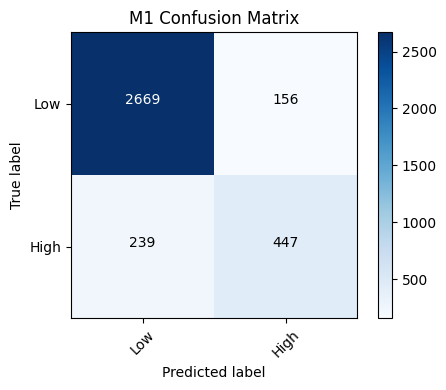


=== Model 2: 0 vs 1 ===
              precision    recall  f1-score   support

           0     0.9334    0.6304    0.7525      2581
           1     0.1183    0.5246    0.1931       244

    accuracy                         0.6212      2825
   macro avg     0.5259    0.5775    0.4728      2825
weighted avg     0.8630    0.6212    0.7042      2825



2025-08-19 20:14:45.087187: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


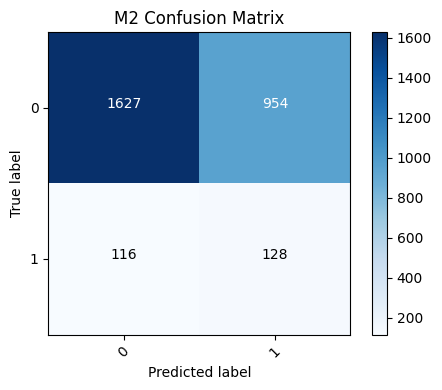


=== Model 3: 2/3/4 (ordinal 2-bit) ===
              precision    recall  f1-score   support

           2     0.8704    0.9395    0.9036       529
           3     0.4762    0.3448    0.4000        87
           4     0.8077    0.6000    0.6885        70

    accuracy                         0.8294       686
   macro avg     0.7181    0.6281    0.6641       686
weighted avg     0.8140    0.8294    0.8178       686



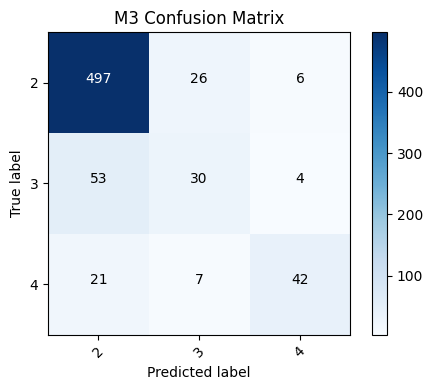


=== Unified system: 0..4 ===
              precision    recall  f1-score   support

           0     0.8674    0.6083    0.7151      2581
           1     0.1047    0.4713    0.1714       244
           2     0.5629    0.5161    0.5385       529
           3     0.4677    0.3333    0.3893        87
           4     0.7143    0.5714    0.6349        70

    accuracy                         0.5773      3511
   macro avg     0.5434    0.5001    0.4898      3511
weighted avg     0.7556    0.5773    0.6410      3511



2025-08-19 20:18:36.784728: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


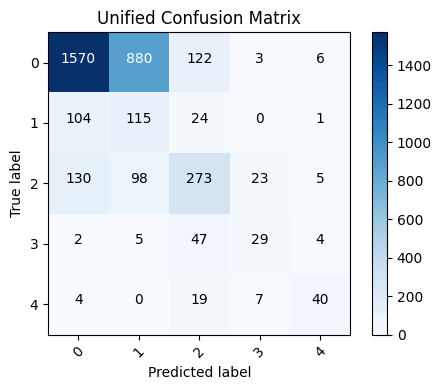


Done.


In [6]:
# -*- coding: utf-8 -*-
"""
Evaluation + Unified Prediction for 3 EfficientNetB3 models.

- Model 1: Low(0,1) vs High(2,3,4)      -> sigmoid(1)
- Model 2: 0 vs 1                        -> sigmoid(1)
- Model 3: Ordinal for {2,3,4}: [y>=3, y>=4] -> sigmoid(2)
Mapping ordinal: 2->[0,0], 3->[1,0], 4->[1,1]

This script:
1) Đánh giá từng model với classification report + confusion matrix.
2) Dự đoán hợp nhất (fuse) -> nhãn cuối 0..4 và đánh giá tổng thể.

Yêu cầu:
- Đã train xong các model và lưu .keras như trong tên file dưới.
- Thư mục VAL_DIR/TEST_DIR theo cấu trúc Keras: root/(0|1|2|3|4)/*.jpg
"""

import os, gc, random, numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ============== CONFIG ==============
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Đổi sang TEST_DIR nếu muốn đánh giá trên test
ROOT_DIR = "/home/duc/Documents/DoAn/eyepacs_2015/test_preprocess_ben_graham"

IMAGE_SIZE = 300
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Đường dẫn model cuối cùng (đã fine-tune xong)
M1_PATH = "output_three_models_eyepacs/effb3_low_high_stage4.keras"
M2_PATH = "output_three_models_eyepacs/effb3_0_vs_1_stage4.keras"
M3_PATH = "output_three_models_eyepacs/effb3_234_ordinal2bit_stage4.keras"

# Ngưỡng
TH_BIN = 0.5   # cho sigmoid nhị phân (M1/M2)
TH_ORD = 0.5   # cho 2-bit ordinal (M3)

# ============== GPU ==============
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception:
            pass

# ============== Data helpers ==============
CLASS_NAMES = ["0","1","2","3","4"]
CLASS_TO_INT = {c:i for i,c in enumerate(CLASS_NAMES)}  # "0"->0, ..., "4"->4

def list_images_with_labels(root, class_names=CLASS_NAMES):
    paths, labels = [], []
    for c in class_names:
        cdir = os.path.join(root, c)
        if not os.path.isdir(cdir):
            continue
        for fname in os.listdir(cdir):
            if fname.lower().endswith((".jpg",".jpeg",".png",".bmp",".tiff",".webp")):
                paths.append(os.path.join(cdir, fname))
                labels.append(int(c))
    return paths, np.array(labels, dtype=np.int32)

def _read_resize_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE), method="bicubic")
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img

def make_dataset(root, batch_size=BATCH_SIZE, shuffle=False):
    paths, labels = list_images_with_labels(root, CLASS_NAMES)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=False)
    def _map(path, y):
        img = _read_resize_preprocess(path)
        return img, y
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
    return ds, paths, labels

# ============== Utility: plots & printing ==============
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    fig = plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.0 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def enforce_monotonic_ord(p_ord):
    """
    Ensure p(y>=4) <= p(y>=3) for ordinal outputs.
    p_ord: (N,2) -> [:,0]=p_ge3, [:,1]=p_ge4
    """
    p = p_ord.copy()
    p[:,1] = np.minimum(p[:,1], p[:,0])
    return p

def bits_to_234(bits):
    """
    bits: (N,2), each in {0,1}, [b_ge3, b_ge4]
    Decode to {2,3,4}:
      [0,0] -> 2
      [1,0] -> 3
      [1,1] -> 4
      [0,1] (invalid) -> fix to 3
    """
    out = np.full((bits.shape[0],), 3, dtype=np.int32)
    cond00 = (bits[:,0]==0) & (bits[:,1]==0)
    cond10 = (bits[:,0]==1) & (bits[:,1]==0)
    cond11 = (bits[:,0]==1) & (bits[:,1]==1)
    out[cond00] = 2
    out[cond10] = 3
    out[cond11] = 4
    return out

# ============== Load models ==============
def load_model_safely(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model not found: {path}")
    return tf.keras.models.load_model(path, compile=False)

# ============== Evaluate Model 1: Low vs High ==============
def evaluate_model1(ds, y_true_0to4, m1, th=TH_BIN):
    # y_true_bin: 0 (low {0,1}), 1 (high {2,3,4})
    y_true_bin = (y_true_0to4 >= 2).astype(np.int32)
    y_pred_prob = []
    for xb, _ in ds:
        p = m1.predict(xb, verbose=0)
        y_pred_prob.append(p.ravel())
    y_pred_prob = np.concatenate(y_pred_prob, axis=0)
    y_pred = (y_pred_prob >= th).astype(np.int32)

    print("\n=== Model 1: Low(0,1) vs High(2,3,4) ===")
    print(classification_report(y_true_bin, y_pred, target_names=["Low(0,1)","High(2,3,4)"], digits=4))
    cm = confusion_matrix(y_true_bin, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, labels=["Low","High"], title="M1 Confusion Matrix")
    return y_pred, y_pred_prob

# ============== Evaluate Model 2: 0 vs 1 ==============
def evaluate_model2(root_dir, m2, th=TH_BIN):
    # chỉ dùng lớp 0 và 1
    ds01, _, y_true01 = make_dataset(root_dir, shuffle=False)
    # lọc chỉ 0,1 ở y_true
    # (make_dataset đã lấy đủ 0..4; ta chỉ dựa vào root_dir có đủ 0,1)
    mask = (y_true01 <= 1)
    if not np.any(mask):
        print("\n[WARNING] Không tìm thấy lớp 0/1 trong thư mục để đánh giá M2.")
        return None, None, None
    # để đơn giản, tạo lại ds chỉ chứa 0/1
    paths_all, labels_all = list_images_with_labels(root_dir, CLASS_NAMES)
    paths01 = [p for p,l in zip(paths_all, labels_all) if l in (0,1)]
    y_true01 = np.array([l for l in labels_all if l in (0,1)], dtype=np.int32)

    # build ds 0/1 riêng
    def gen01():
        for p in paths01:
            yield p
    ds_paths = tf.data.Dataset.from_generator(gen01, output_signature=tf.TensorSpec(shape=(), dtype=tf.string))
    ds_img = ds_paths.map(lambda p: (_read_resize_preprocess(p)), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    y_pred_prob = []
    for xb in ds_img:
        p = m2.predict(xb, verbose=0)
        y_pred_prob.append(p.ravel())
    y_pred_prob = np.concatenate(y_pred_prob, axis=0)
    y_pred = (y_pred_prob >= th).astype(np.int32)

    print("\n=== Model 2: 0 vs 1 ===")
    print(classification_report(y_true01, y_pred, target_names=["0","1"], digits=4))
    cm = confusion_matrix(y_true01, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, labels=["0","1"], title="M2 Confusion Matrix")
    return y_true01, y_pred, y_pred_prob

# ============== Evaluate Model 3: 2/3/4 ordinal ==============
def evaluate_model3(root_dir, m3, th=TH_ORD):
    # chỉ dùng lớp 2,3,4
    paths_all, labels_all = list_images_with_labels(root_dir, CLASS_NAMES)
    mask = np.isin(labels_all, [2,3,4])
    if not np.any(mask):
        print("\n[WARNING] Không tìm thấy lớp 2/3/4 trong thư mục để đánh giá M3.")
        return None, None, None
    paths234 = [p for p,l in zip(paths_all, labels_all) if l in (2,3,4)]
    y_true234 = np.array([l for l in labels_all if l in (2,3,4)], dtype=np.int32)

    def gen234():
        for p in paths234:
            yield p
    ds_paths = tf.data.Dataset.from_generator(gen234, output_signature=tf.TensorSpec(shape=(), dtype=tf.string))
    ds_img = ds_paths.map(lambda p: (_read_resize_preprocess(p)), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    proba = []
    for xb in ds_img:
        p = m3.predict(xb, verbose=0)  # (B,2) [p_ge3, p_ge4]
        proba.append(p)
    proba = np.concatenate(proba, axis=0)
    proba = enforce_monotonic_ord(proba)
    bits = (proba >= th).astype(np.int32)
    y_pred234 = bits_to_234(bits)

    print("\n=== Model 3: 2/3/4 (ordinal 2-bit) ===")
    # classification_report với labels [2,3,4]
    print(classification_report(y_true234, y_pred234, labels=[2,3,4], target_names=["2","3","4"], digits=4))
    cm = confusion_matrix(y_true234, y_pred234, labels=[2,3,4])
    plot_confusion_matrix(cm, labels=["2","3","4"], title="M3 Confusion Matrix")
    return y_true234, y_pred234, proba

# ============== Unified prediction (0..4) ==============
def unified_predict_and_eval(root_dir, m1, m2, m3, th_bin=TH_BIN, th_ord=TH_ORD):
    ds, paths, y_true = make_dataset(root_dir, shuffle=False)
    y_pred_all = []

    for xb, yb in ds:
        # 1) Low/High by M1: p_high
        p_high = m1.predict(xb, verbose=0).ravel()
        is_high = (p_high >= th_bin)

        # 2) Route low -> M2 ; high -> M3
        # Low subset
        x_low = xb[~is_high]
        # High subset
        x_high = xb[is_high]

        # Prepare container for this batch
        y_pred_batch = np.empty((xb.shape[0],), dtype=np.int32)

        # Low -> 0/1
        if x_low.shape[0] > 0:
            p01 = m2.predict(x_low, verbose=0).ravel()
            y01 = (p01 >= th_bin).astype(np.int32)  # 0 or 1
            y_pred_batch[~is_high] = y01

        # High -> 2/3/4 via ordinal
        if x_high.shape[0] > 0:
            p_ord = m3.predict(x_high, verbose=0)  # (n_high,2)
            p_ord = enforce_monotonic_ord(p_ord)
            bits = (p_ord >= th_ord).astype(np.int32)
            y234 = bits_to_234(bits)
            y_pred_batch[is_high] = y234

        y_pred_all.append(y_pred_batch)

    y_pred_all = np.concatenate(y_pred_all, axis=0)

    print("\n=== Unified system: 0..4 ===")
    print(classification_report(y_true, y_pred_all, labels=[0,1,2,3,4], target_names=["0","1","2","3","4"], digits=4))
    cm = confusion_matrix(y_true, y_pred_all, labels=[0,1,2,3,4])
    plot_confusion_matrix(cm, labels=["0","1","2","3","4"], title="Unified Confusion Matrix")

    return paths, y_true, y_pred_all

# ============== MAIN ==============
if __name__ == "__main__":
    tf.keras.backend.clear_session(); gc.collect()

    # Load models
    print("Loading models...")
    m1 = load_model_safely(M1_PATH)  # Low/High
    m2 = load_model_safely(M2_PATH)  # 0 vs 1
    m3 = load_model_safely(M3_PATH)  # 2/3/4 ordinal

    # Evaluate M1 on full folder (0..4)
    ds_full, paths_full, y_full = make_dataset(ROOT_DIR, shuffle=False)
    _m1_pred, _m1_prob = evaluate_model1(ds_full, y_full, m1, th=TH_BIN)

    # Evaluate M2 on 0/1 subset (if available)
    evaluate_model2(ROOT_DIR, m2, th=TH_BIN)

    # Evaluate M3 on 2/3/4 subset (if available)
    evaluate_model3(ROOT_DIR, m3, th=TH_ORD)

    # Unified evaluation on full folder (0..4)
    unified_predict_and_eval(ROOT_DIR, m1, m2, m3, th_bin=TH_BIN, th_ord=TH_ORD)

    print("\nDone.")


Loading models...
Loaded.
Found 3511 images for evaluation.

==== Routing summary ====
Pick m2 directly: 3464
Pick m3 directly: 28
Fallback via m1 -> low (use m2): 15
Fallback via m1 -> high (use m3): 4

Classification Report (0..4):
              precision    recall  f1-score   support

           0     0.7809    0.6284    0.6964      2581
           1     0.0899    0.5164    0.1531       244
           2     0.4483    0.0246    0.0466       529
           3     0.0000    0.0000    0.0000        87
           4     1.0000    0.0286    0.0556        70

    accuracy                         0.5021      3511
   macro avg     0.4638    0.2396    0.1903      3511
weighted avg     0.6678    0.5021    0.5307      3511



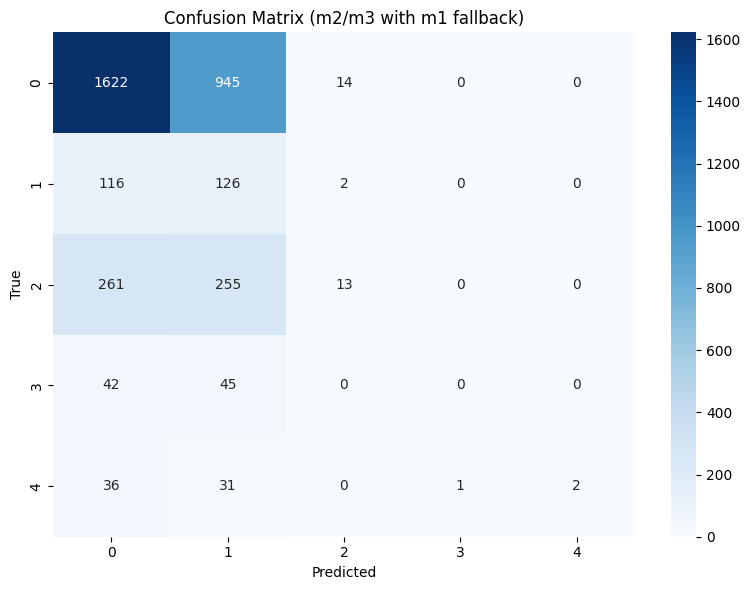

In [8]:
# evaluate_three_models_rule_based.py
# -----------------------------------
# Luồng gán nhãn:
# 1) Đưa ảnh vào cả 3 model (m1: low/high, m2: 0/1, m3: 2/3/4 ordinal 2-bit).
# 2) Nếu p_m2 in [1e-5, 0.99999] -> gán nhãn theo m2 (0/1) rồi thoát.
# 3) Ngược lại (p_m2 ngoài khoảng), xét m3:
#    Nếu cả 2 giá trị đầu ra của m3 >= 1e-8 -> gán nhãn theo m3 (2/3/4) rồi thoát.
# 4) Nếu vẫn không thoả, dùng m1 quyết định route:
#    - m1=low -> lấy nhãn m2 (0/1, theo ngưỡng 0.5)
#    - m1=high -> lấy nhãn m3 (2/3/4, theo ordinal decode)
#
# Đánh giá: classification_report + confusion matrix heatmap.

import os
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ================== CONFIG ==================
IMAGE_SIZE = 300  # dùng đúng kích thước lúc train các model EffNetB3
TH_BIN = 0.5

M1_PATH = "output_three_models_eyepacs/effb3_low_high_stage4.keras"
M2_PATH = "output_three_models_eyepacs/effb3_0_vs_1_stage4.keras"
M3_PATH = "output_three_models_eyepacs/effb3_234_ordinal2bit_stage4.keras"

# Thư mục test có cấu trúc: TEST_DIR/0..4/*.jpg
TEST_DIR = "/home/duc/Documents/DoAn/eyepacs_2015/test_preprocess_ben_graham"

# Ngưỡng theo yêu cầu
M2_MIN, M2_MAX = 1e-8, 0.99999   # khoảng “chấp nhận ngay” cho m2
M3_MIN,M3_MAX = 1e-8,0.99999                    # cả 2 giá trị m3 phải >= M3_MIN để “chấp nhận ngay”
BATCH_SIZE = 16

# ================== GPU optional ==================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception:
            pass

# ================== Helpers ==================
def list_images_with_labels(root):
    paths, labels = [], []
    for cls in ["0","1","2","3","4"]:
        cdir = Path(root) / cls
        if not cdir.is_dir():
            continue
        for p in sorted(cdir.glob("*")):
            if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff"]:
                paths.append(str(p))
                labels.append(int(cls))
    return np.array(paths), np.array(labels, dtype=np.int32)

def load_and_preprocess_batch(filepaths, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    H, W = target_size
    imgs = []
    for fp in filepaths:
        img = tf.io.read_file(fp)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, (H, W), method="bicubic")
        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)  # EfficientNet preprocess
        imgs.append(img)
    return tf.stack(imgs, axis=0).numpy()

def m1_prob_high(y):
    """m1 nhị phân low/high. Hỗ trợ (N,1) sigmoid hoặc (N,2) softmax."""
    y = np.asarray(y)
    p_high = y[:, 0]  # sigmoid
    
    return p_high
def m2_prob_class1(y):
    """m2 0/1. Trả về p(class 1)."""
    y = np.asarray(y)
    p1 = y[:, 0]  # sigmoid
    return p1

def m3_decode_234(y2bit):
    """
    m3 ordinal 2-bit (giả định [p>=3, p>=4] sau sigmoid).
    Suy ra phân phối trên {2,3,4}:
      p2 = 1 - p>=3
      p3 = p>=3 - p>=4
      p4 = p>=4
    Trả về: (labels_234, dist_234) với labels_234 ∈ {2,3,4}
    """
    y = np.asarray(y2bit, dtype=np.float32)
    if y.ndim != 2 or y.shape[1] != 2:
        raise ValueError("m3 (ordinal 2-bit) phải có shape (N,2) ~ [p>=3, p>=4].")
    p_ge3, p_ge4 = y[:, 0], y[:, 1]
    p2 = 1.0 - p_ge3
    p3 = p_ge3 - p_ge4
    p4 = p_ge4
    P = np.stack([p2, p3, p4], axis=1)
    P = np.clip(P, 1e-9, None)
    P = P / P.sum(axis=1, keepdims=True)
    labels_local = np.argmax(P, axis=1)  # 0->2, 1->3, 2->4
    labels_global = labels_local + 2
    return labels_global, P

def batch_indices(n, bs):
    i = 0
    while i < n:
        j = min(i + bs, n)
        yield i, j
        i = j

# ================== Load models ==================
print("Loading models...")
m1 = tf.keras.models.load_model(M1_PATH, compile=False)
m2 = tf.keras.models.load_model(M2_PATH, compile=False)
m3 = tf.keras.models.load_model(M3_PATH, compile=False)
print("Loaded.")

# ================== Load test set ==================
files, y_true = list_images_with_labels(TEST_DIR)
if len(files) == 0:
    raise RuntimeError(f"Không tìm thấy ảnh trong: {TEST_DIR}")
N = len(files)
print(f"Found {N} images for evaluation.")

# ================== Predict (batched) ==================
y_pred = np.zeros((N,), dtype=np.int32)

# Đếm xem mỗi quyết định đi theo nhánh nào (để bạn quan sát)
cnt_pick_m2 = 0
cnt_pick_m3 = 0
cnt_pick_m1_route_low = 0
cnt_pick_m1_route_high = 0

for a, b in batch_indices(N, BATCH_SIZE):
    fps = files[a:b]
    xb = load_and_preprocess_batch(fps, (IMAGE_SIZE, IMAGE_SIZE))

    y1_raw = m1.predict(xb, verbose=0)  # low/high
    y2_raw = m2.predict(xb, verbose=0)  # 0/1
    y3_raw = m3.predict(xb, verbose=0)  # 2-bit ordinal

    # Chuẩn bị các biến xác suất/nhãn
    p1_high = m1_prob_high(y1_raw)               # (B,)
    p2_one  = m2_prob_class1(y2_raw)             # (B,)
    lab2    = (p2_one >= TH_BIN).astype(np.int32)  # 0/1
    lab3, dist3 = m3_decode_234(y3_raw)          # ∈ {2,3,4}

    # Điều kiện m2 “chấp nhận ngay”
    accept_m2 = (p2_one >= M2_MIN) & (p2_one <= M2_MAX)

    # Giá trị max prob của m3
    m3_max = np.max(dist3, axis=1)  
    # Điều kiện m3 "chấp nhận ngay": max nằm trong khoảng [M3_MIN, M3_MAX]
    m3_accept = (m3_max >= M3_MIN) & (m3_max <= M3_MAX)
    
    
    
    for i_rel in range(b - a):
        # Ưu tiên m2 nếu trong khoảng
        if accept_m2[i_rel]:
            y_pred[a + i_rel] = int(lab2[i_rel])  # 0 hoặc 1
            cnt_pick_m2 += 1
            continue

        # Nếu m2 KHÔNG trong khoảng, xét m3
        if m3_accept[i_rel]:
            y_pred[a + i_rel] = int(lab3[i_rel])  # 2/3/4
            cnt_pick_m3 += 1
            continue

        # Fallback: dùng m1 quyết định route
        if p1_high[i_rel] >= TH_BIN:
            # high -> dùng nhãn m3
            y_pred[a + i_rel] = int(lab3[i_rel])  # 2/3/4
            cnt_pick_m1_route_high += 1
        else:
            # low -> dùng nhãn m2
            y_pred[a + i_rel] = int(lab2[i_rel])  # 0/1
            cnt_pick_m1_route_low += 1

print("\n==== Routing summary ====")
print(f"Pick m2 directly: {cnt_pick_m2}")
print(f"Pick m3 directly: {cnt_pick_m3}")
print(f"Fallback via m1 -> low (use m2): {cnt_pick_m1_route_low}")
print(f"Fallback via m1 -> high (use m3): {cnt_pick_m1_route_high}")

# ================== Evaluation ==================
print("\nClassification Report (0..4):")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (m2/m3 with m1 fallback)")
plt.tight_layout()
plt.show()
